# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=ac57bb6702d53af6725a73963af42762a33539ca3e998e37b1c2a2fadbaf7abe
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict
from surprise import accuracy  # Import accuracy directly from surprise

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
df=pd.read_csv('/content/ratings_Electronics.csv')

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [5]:
df.columns = ['userId', 'productId', 'rating', 'timestamp']
df

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [6]:
# Get the column containing the users
users = df.userId

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [7]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.userId.isin(remove_users)]

In [8]:
# Get the column containing the products
prods = df.productId

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [9]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.productId.isin(remove_users)]

In [10]:
# Print a few rows of the imported dataset
df_final.head()

,userId,productId,rating,timestamp
1309,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1321,A1A5KUIIIHFF4U,1400501466,1.0,1332547200
1334,A2XIOXRRYX0KZY,1400501466,3.0,1371686400
1450,AW3LX47IHPFRL,1400501466,5.0,1339804800
1455,A1E3OB6QMBKRYZ,1400501466,1.0,1350086400


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [11]:
# Check the number of rows and columns and provide observations
df.shape

(125871, 4)


**Write your observations here:______**

It has 125871 rows and 4 columns

### **Data types**

In [12]:
# Check Data types and provide observations
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125871 entries, 93 to 7824443
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125871 non-null  object 
 1   productId  125871 non-null  object 
 2   rating     125871 non-null  float64
 3   timestamp  125871 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.8+ MB


**Write your observations here:______**
The userId, productId are of object datatype while rating is in float datatype and timestamp is in integer datatype



### **Checking for missing values**

*   List item
*   List item



In [13]:
# Check for missing values present and provide observations
df.isnull()


,userId,productId,rating,timestamp
93,False,False,False,False
117,False,False,False,False
176,False,False,False,False
177,False,False,False,False
491,False,False,False,False
...,...,...,...,...
7824425,False,False,False,False
7824426,False,False,False,False
7824435,False,False,False,False
7824437,False,False,False,False


**Write your observations here:______**

If there is any null value in the dataframe it is returned as true while others are returned as false



### **Summary Statistics**

In [14]:
# Summary statistics of 'rating' variable and provide observations
df.describe()


,rating,timestamp
count,125871.000000,1.258710e+05
mean,4.261339,1.321979e+09
std,1.062144,7.583599e+07
min,1.000000,9.396000e+08
25%,4.000000,1.286928e+09
50%,5.000000,1.346717e+09
75%,5.000000,1.377130e+09
max,5.000000,1.406074e+09


### **Checking the rating distribution**

**Write your observations here:______**

For the numerical columns rating and timestamp the mean is 4.2 and 1.32 respectively
while min and max vales are 1 and 5 for rating while for timestaml it is 9.39x10^8 and 1.40x10^9

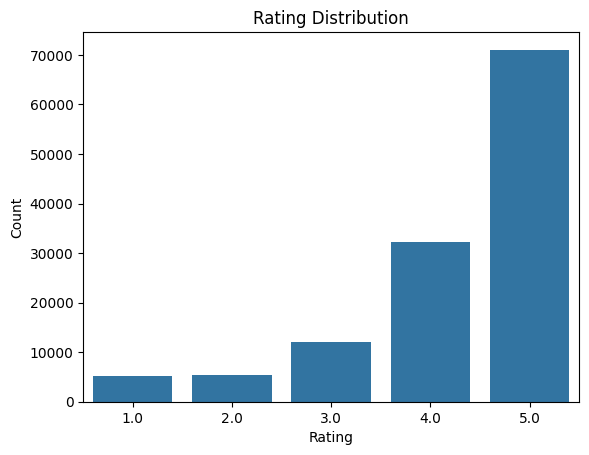

In [15]:
# Create the bar plot and provide observations
sns.countplot(data=df, x='rating')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Write your observations here:________**

For about 70000 counts if users they have rated 5



### **Checking the number of unique users and items in the dataset**

In [16]:
# Number of total rows in the data and number of unique user id and product id in the data
df['userId'].nunique()

1540

**Write your observations here:_______**

There are about 1540 unique values in the frame

### **Users with the most number of ratings**

In [17]:
# Top 10 users based on the number of ratings
top_users = df.groupby('userId').size().sort_values(ascending=False).head(10)
top_users

,0
userId,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


**Write your observations here:_______**

A5JLAU2ARJ0BO has the most number of rating 520 followed by ADLVFFE4VBT8	 aving 501 ratings





**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [18]:
# Calculate the average rating for each product
average_rating = df.groupby('productId')['rating'].mean()
df


,userId,productId,rating,timestamp
93,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
117,AT09WGFUM934H,0594481813,3.0,1377907200
176,A32HSNCNPRUMTR,0970407998,1.0,1319673600
177,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
491,A3CLWR1UUZT6TG,0972683275,5.0,1373587200
...,...,...,...,...
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0,1405641600
7824426,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0,1405209600
7824435,A3AYSYSLHU26U9,B00LI4ZZO8,4.0,1405296000
7824437,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0,1405209600


In [19]:

# Calculate the count of ratings for each product
rating_count = df.groupby('productId')['rating'].count()
df


,userId,productId,rating,timestamp
93,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
117,AT09WGFUM934H,0594481813,3.0,1377907200
176,A32HSNCNPRUMTR,0970407998,1.0,1319673600
177,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
491,A3CLWR1UUZT6TG,0972683275,5.0,1373587200
...,...,...,...,...
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0,1405641600
7824426,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0,1405209600
7824435,A3AYSYSLHU26U9,B00LI4ZZO8,4.0,1405296000
7824437,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0,1405209600


In [20]:
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating': average_rating, 'rating_count': rating_count})
df
# Sort the dataframe by average of ratings in the descending order
final_rating_sorted = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
print(final_rating_sorted.head())

            average_rating  rating_count
productId                               
0594451647             5.0             1
B003RRY9RS             5.0             1
B003RR95Q8             5.0             1
B003RIPMZU             5.0             1
B003RFRNYQ             5.0             2


In [21]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(df, final_rating, n, min_interactions=100):
  # Calculate rating count and merge it with the original dataframe
  rating_count = df.groupby('productId')['rating'].count().reset_index(name='rating_count')
  average_rating = df.groupby('productId')['rating'].mean().reset_index(name='average_rating')
  df_with_counts = df.merge(rating_count, on='productId', how='left')
  df_with_counts = df_with_counts.merge(average_rating, on='productId', how='left') # Merge average rating into df_with_counts

  recommendations = df_with_counts[df_with_counts['rating_count'] > min_interactions]
  recommendations = recommendations.sort_values(by='average_rating', ascending=False)
  return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
res = top_n_products(df, final_rating, 5, 50) # Pass df to the function
# Name of the books
listofproducts = []
for i in res:
    # No need to filter and use unique() now
    listofproducts.append(i)
for product_id in listofproducts:
      # Extract product name
    print(f"Product ID: {product_id}")


Product ID: 41161
Product ID: 41190
Product ID: 41197
Product ID: 41196
Product ID: 41195


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
res = top_n_products(df, final_rating, 5, 100) # Pass df to the function
# Name of the books
listofproducts = []
for i in res:
    # No need to filter and use unique() now
    listofproducts.append(i)
for product_id in listofproducts:
      # Extract product name
    print(f"Product ID: {product_id}")


Product ID: 57313
Product ID: 57323
Product ID: 57196
Product ID: 57315
Product ID: 57316


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [24]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV
from surprise import SVD,Dataset
from surprise.model_selection import train_test_split

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [25]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [26]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset

# Splitting the data into train and test datasets
data = Dataset.load_from_df(df_final[['userId', 'productId', 'rating']], reader) # Use the correct column names: userId and productId
trainset, testset = train_test_split(data, test_size=0.2)


In [27]:
df.head()

,userId,productId,rating,timestamp
93,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
117,AT09WGFUM934H,0594481813,3.0,1377907200
176,A32HSNCNPRUMTR,0970407998,1.0,1319673600
177,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
491,A3CLWR1UUZT6TG,0972683275,5.0,1373587200


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [28]:
# Import the necessary class from the surprise library
from surprise import KNNBasic

# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # Similarity measure: cosine similarity
    'user_based': True  # User-based collaborative filtering
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_model = KNNBasic(sim_options=sim_options, verbose=False)

# Fit the model on the training data
knn_model.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_model)



RMSE: 1.0101
Precision:  0.859
Recall:  0.859
F_1 score:  0.859


**Write your observations here:__________**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [29]:
# Predicting rating for a sample user with an interacted product
knn_model.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291219941798132, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:__________**

there is no difference in the prediction of the baseline model and the tuned model for this particular user-item pair. Both models predicted the rating as 4.46, which is very close to the actual rating of 5.



Below is the **list of users who have not seen the product with product id "1400501466"**.

In [30]:
# Find unique user_id where prod_id is not equal to "1400501466"
filtered_users = df[df['productId'] != "1400501466"]['userId'].unique()
filtered_users

array(['A3BY5KCNQZXV5U', 'AT09WGFUM934H', 'A32HSNCNPRUMTR', ...,
       'AT53ZTTO707MB', 'A1X3ESYZ79H59E', 'A328S9RN3U5M68'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [31]:
# Predicting rating for a sample user with a non interacted product
prediction = knn_model.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


**Write your observations here:__________**

The predicted rating for the user A34BZM6S9L7QI4 is 4.29



### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [32]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [22, 35, 45], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9718548544503283
{'k': 45, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [33]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=20, min_k=6, verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10.
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9531
Precision:  0.848
Recall:  0.894
F_1 score:  0.87


**Write your observations here:__________**

After tuning hyperparameters, RMSE for the test set has reduced from 1.01 to 0.9531.
We can observe that after tuning the hyperparameters, the tuned model's F-1 score increased from 0.85 to 0.0.87 in comparison to the baseline model. As a result, we can say that the model's performance has improved after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [34]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291219941798132, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [35]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized.predict('A34BZM6S9L7QI4', 1400501466, r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=5, est=4.291219941798132, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**____________

for  useridA3LDPF5FMB782Z and useridA34BZM6S9L7QI4 there is no much difference in rating prediction its only from 4.46 to 4.56




### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [36]:
# 0 is the inner id of the above user
similarity_algo_optimized.get_neighbors(0, k=5)

[2, 11, 13, 17, 19]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [66]:
def get_recommendations(data, user_id, top_n, algo):
    recommendations = []
    user_item_interactions_matrix = data.pivot(index='userId', columns='productId', values='rating')

    # Convert index to string type to ensure consistency
    user_item_interactions_matrix.index = user_item_interactions_matrix.index.astype(str)
    user_id = str(user_id).strip()  # Convert the provided user_id to string and remove any leading/trailing spaces

    # Debugging: Print user_id and index to check for issues
    print(f"User ID provided: '{user_id}'")
    print(f"Available user IDs in the matrix index: {user_item_interactions_matrix.index.tolist()}")

    # Check if the user_id exists in the DataFrame index
    if user_id not in user_item_interactions_matrix.index:
        print(f"User ID '{user_id}' not found in the data.")
        return recommendations  # Return an empty list if user not found

    # Extracting those product ids which the user_id has not interacted with yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Loop through each product id that the user has not interacted with
    for item_id in non_interacted_products:
        # Predict the ratings for non-interacted product ids for this user
        est = algo.predict(user_id, item_id).est
        # Append the predicted ratings
        recommendations.append((item_id, est))

    # Sort the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n]


**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [67]:
if 'A3LDPF5FMB782Z' in df['userId'].values:
    print("User ID 'A3LDPF5FMB782Z' is found in the DataFrame!")
else:
  print("no")

User ID 'A3LDPF5FMB782Z' is found in the DataFrame!


In [68]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df, user_id="A3LDPF5FMB782Z", top_n=5, algo=similarity_algo_optimized)


User ID provided: 'A3LDPF5FMB782Z'
Available user IDs in the matrix index: ['A100UD67AHFODS', 'A100WO06OQR8BQ', 'A105S56ODHGJEK', 'A105TOJ6LTVMBG', 'A10AFVU66A79Y1', 'A10H24TDLK2VDP', 'A10NMELR4KX0J6', 'A10O7THJ2O20AG', 'A10PEXB6XAQ5XF', 'A10X9ME6R66JDX', 'A10Y058K7B96C6', 'A10ZBR6O8S8OCY', 'A10ZFE6YE0UHW8', 'A110PC8C5Y7MQD', 'A110VKXAVLAYKY', 'A111WCUF5KA2I6', 'A1143YEAZYMYHJ', 'A11D1KHM7DVOQK', 'A11ED8O95W2103', 'A11EXFO14WEJM1', 'A11EYMH9UV9XG7', 'A11FX8HL2ANK6T', 'A11I1I9QLMAM1A', 'A11IXJ8M1JO296', 'A11KQADBYE0UZL', 'A11KZ906QD08C5', 'A11LNPG39A2ZV4', 'A11OTLEDSW8ZXD', 'A11P105WVK5240', 'A11R5VW7IM6ISQ', 'A11T807LX2EF00', 'A11ULAZ4B5ZXC8', 'A11YIHB6IW352W', 'A11YOTONCPRQ9S', 'A124WZCUIH2T7W', 'A12ANFNOSMW5VD', 'A12DLJESJKM1OQ', 'A12DQZKRKTNF5E', 'A12EVK82QUTSA6', 'A12LH2100CKQO', 'A12O5SEIF162P8', 'A12R3YGEHW7D8G', 'A132ETQPMHQ585', 'A13BX9O5UDBILC', 'A13EQE9EY2ET93', 'A13QOK3SKIT9QL', 'A13WOT3RSXKRD5', 'A13WREJ05GMRA6', 'A141OPVE376YFI', 'A141R97FHSSUQ0', 'A1435P5AMCPB3X', 'A145B8

In [69]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B0012Y6HC8,5
2,B001FA1NK0,5
3,B001TH7GSW,5
4,B001TH7GUU,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [70]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=20, min_k=6, verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)

# Generate predictions on the testset
# Assuming you have a 'testset' variable similar to 'trainset'
predictions_optimized = similarity_algo_optimized.test(testset) # Rename the variable to avoid overwriting

# Let us compute precision@k and recall@k with k=10.
precision_recall_at_k(similarity_algo_optimized) # Pass the model object instead of the predictions list

RMSE: 0.9531
Precision:  0.848
Recall:  0.894
F_1 score:  0.87


**Write your observations here:**____________

The rmse value has further decreaed now to 0.951
while F1 score has increased to 0.87 increasing the accuracy



Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [71]:
# Predicting rating for a sample user with an interacted product
similarity_algo_optimized.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291219941798132, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**____________

prediction for rating for A3LDPF5FMB782Z is 4.29



Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [72]:
# Predicting rating for a sample user with a non interacted product
similarity_algo_optimized.predict('A34BZM6S9L7QI4', 1400501466, r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=5, est=4.291219941798132, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**____________

prediction for rating for A34BZM6S9L7QI4 is 4.29




### **Hyperparameter tuning the item-item

1.   List item
2.   List item

similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [113]:
# Defining similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the train set
algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k=10
precision_recall_at_k(algo_knn_item)

RMSE: 1.0186
Precision:  0.835
Recall:  0.84
F_1 score:  0.837


**Write your observations here:__________**

the rmse value is 1.0186, precision is .835 while f1 score is .837


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [75]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
algo_knn_item.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291219941798132, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [76]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
algo_knn_item.predict('A34BZM6S9L7QI4', 1400501466, r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=5, est=4.291219941798132, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:__________**

The predicition values are same for both the users with rating 4.29



### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [77]:
algo_knn_item.get_neighbors(0, k=5)

[20, 77, 92, 109, 111]

**Predicting top 5 products for userId =

*   List item
*   List item

"A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [78]:
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder

data = df[['userId', 'productId']].apply(LabelEncoder().fit_transform)

In [79]:
df_rating=data.copy()

In [99]:
df['userId_encoded'] = LabelEncoder().fit_transform(df['userId'])  # Add the encoded column to 'df'

def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended book ids
    recommendations = []

    # Creating an user item interactions matrix
    # Use 'userId' instead of 'user_id' to match the column name in the DataFrame
    user_item_interactions_matrix = data.pivot(index='userId', columns='productId', values='rating')

    # Find the numerical label corresponding to the original user ID
    # Assuming 'df' is the original DataFrame before Label Encoding
    user_id_label = df[df['userId'] == user_id]['userId_encoded'].iloc[0]  # Replace 'userId_encoded' with the actual column name if different

    # Extracting those book ids which the user_id has not interacted with yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id_label][user_item_interactions_matrix.loc[user_id_label].isnull()].index.tolist()

    # Looping through each of the book id which user_id has not interacted with yet
    for book_id in non_interacted_items:

        # Predicting the ratings for those non interacted book ids by this user
        est = algo.predict(user_id_label, book_id).est  # Use the label for prediction

        # Appending the predicted ratings
        recommendations.append((book_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returning top n predicted rating items for this user

In [100]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
acc=get_recommendations(data, 'A1A5KUIIIHFF4U', 5, algo_knn_item)
acc

[(0, 4.291219941798132),
 (1, 4.291219941798132),
 (2, 4.291219941798132),
 (3, 4.291219941798132),
 (5, 4.291219941798132)]

In [101]:
pd.DataFrame(acc)

,0,1
0,0,4.29122
1,1,4.29122
2,2,4.29122
3,3,4.29122
4,5,4.29122


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [102]:
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd)

RMSE: 0.8986
Precision:  0.852
Recall:  0.88
F_1 score:  0.866


**Write your observations here:___________**

The overall accuracy has increased as rmse is now 0.896 while f1 score is 0.866



**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [103]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.17   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.17495767829676, details={'was_impossible': False})

**Write your observations here:___________**

---
now the predicted value for user A3LDPF5FMB782Z's rating is 4.17

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [104]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", 1400501466, r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.58   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=5, est=4.576655079807248, details={'was_impossible': False})

**Write your observations here:___________**


now the predicted value for user A3LDPF5FMB782Z's rating is 4.58


### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

> Add blockquote



Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [107]:
# Assuming 'data' is your DataFrame with columns 'userId', 'productId', and 'rating'
reader = Reader(rating_scale=(1, 5))  # Define rating scale
data_surprise = Dataset.load_from_df(data[['userId', 'productId', 'rating']], reader)

# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data using Surprise Dataset object
gs_.fit(data_surprise)  # Use data_surprise instead of data

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.9802483846562818
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


In [108]:
# Building the optimized SVD model
svd_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2, random_state=1)

# Training the algorithm on the train set
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd_optimized)

RMSE: 0.8892
Precision:  0.853
Recall:  0.883
F_1 score:  0.868


**Write your observations here:_____________**

Further the value of rmse has decreased to 0.8892 while f1 score has increased to 0.868

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [109]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.19   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.190337096986113, details={'was_impossible': False})

In [116]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', 1400501466, r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.55   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=5, est=4.553531722657694, details={'was_impossible': False})

now the predicted value for user A3LDPF5FMB782Z's rating is 4.19 and the predicted value for user A3LDPF5FMB782Z's rating is 4.55

### **Conclusion and Recommendations**


**conclusion**

WE built recommendation systems using the following algorithms. They are as follows:
Item-item similarity-based collaborative filtering
Model-based (matrix factorization) collaborative filtering
To demonstrate these surprise library has been used. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and improve the performance of the model**.

For performance evaluation of these models, precision@k and recall@k are used. Using these two metrics, the F_1 score is calculated for each working model.

Overall, the optimized matrix factorisation-based recommendation system has given the best performance in terms of the F1-Score (~0.86)

Matrix Factorization has lower RMSE (1.50) due to the reason that it assumes that both products and users and ratings are present in some low dimensional space describing their properties and recommend a product based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

We can try to further improve the performance of these models using hyperparameter tuning.



**RECOMMENDATIONS:**

 Personalized Product Recommendations: it could recommend users prodcust according to their taste and hence this could increase their sales

 Send personalized email campaigns showcasing recommended products to individual users

  Identify highly recommended and frequently purchased items to stock up prodcuts

Showcase positive reviews and ratings to build trust and encourage purchases.

Regularly update the recommendation algorithm based on new data and user feedback to improve its performance.





